In [22]:
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from skimage import io
from PIL import Image
import os
import cv2

In [18]:
images_training_folder = 'data/training/images'
annotation_training_folder = 'data/training/labels'

images_test_folder = 'data/test/images'
annotation_test_folder = 'data/test/images'

In [24]:
train_images = []
train_mask = []

for file in sorted(os.listdir(images_training_folder)):
  img = cv2.imread(images_training_folder+'/'+file, 0)
  train_images.append(img)

for file in sorted(os.listdir(annotation_training_folder)):
  img = cv2.imread(annotation_training_folder+'/'+file, 0)
  train_mask.append(img)

In [25]:
test_images = []
test_mask = []

for file in sorted(os.listdir(images_test_folder)):
  img = cv2.imread(images_test_folder+'/'+file, 0)
  test_images.append(img)

for file in sorted(os.listdir(annotation_test_folder)):
  img = cv2.imread(annotation_test_folder+'/'+file, 0)
  test_mask.append(img)

In [8]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    #plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    io.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [14]:
OUTPUT_CHANNELS = 2

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[584, 565, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

C:\Users\Matt\anaconda3\envs\pytest36\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [30]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [33]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [36]:
def show_predictions(num=0):
  pred_mask = model.predict(test_images[num])
  display([test_images[num], test_mask[num], create_mask(pred_mask)])

In [37]:
show_predictions()

ValueError: Error when checking input: expected input_4 to have 4 dimensions, but got array with shape (584, 565)

In [9]:
pic1 = io.imread('data/training/training/images/21_training.tif')
mask1 = io.imread('data/training/training/1st_manual/21_manual1.gif')

In [10]:
len(mask1.shape)

2

In [11]:
len(pic1.shape)

3

In [13]:
pic1.shape

(584, 565, 3)

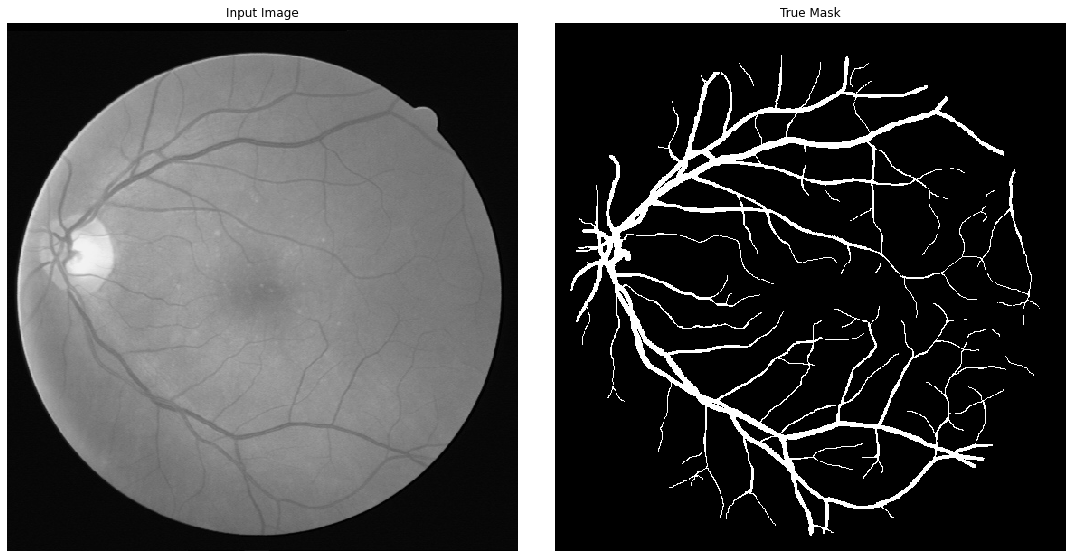

In [26]:
display([train_images[0], train_mask[0]])